# PURPOSE


The pourpose of this jupyter notebook is to put into relation the different csv files related to te DAANMO project in order to find the answers to the target questions. As such, the dfs previously cleaned and explored will be imported and analyze in relation with eachother.

Thusly, the analysis will begin by exploring:

    1) The human resources perspective (actors, directors and producers)
    2) The economic aspect of filmmaking (genre impact through profits)

Still WIP

In [1]:
# LIBRARIES
import pandas as pd
import numpy as np
import ast


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# CSVs
links = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\links_ready.csv')
links_small = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\links_small_ready.csv')
keywords = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\keywords_ready.csv')
actors = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\actors_ready.csv')
producers = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\producers_ready.csv')
directors = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\directors_ready.csv')
genres_unique = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\genres_unique_ready.csv')
genres = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\the-movies-dataset\ready_dfs\genres_ready.csv')

print("csvs ready")

csvs ready


The links df will be used in case any other df of this notebook has NaN values in the "id" section. With the hope to cover this gaps and avoid an unnecessary loss of data.

In [3]:
links.isnull().any()

movieId    False
imdbId     False
tmdbId     False
dtype: bool

# Functions

In [4]:
def mixer (gender_df, genre_df):
    """
                        ---What it does---
    Takes the dfs provided and right-merges them based on the 'id' column. Then it counts and creates a new df with the gender count of the gender_df ('Male' and 'Female' values currently accounted for) and assings it to whatever film genre(s) the 'id' column was assigned to.
                        ---What it needs---
    This function needs:
        - A df object with 'id' and 'gender' columns named as shown here
            + The 'gender' column should contain 'Male' and 'Female' strings.
        - A df object with 'id' and 'genre' columns named as shown here
            + This df can contain embeded lists
                        ---What it returns---
    A new df object with the following columns:
        - genre: a list of chain strings containing one or more film genre (obj, list)
        - male_counts: number of male participants (int)
        - female_counts: number of female participants (int)
    """

    # Merging of dfs
    df3 =pd.merge(gender_df, genre_df, on='id', how='right')

    # Lists creation and gender and genre search
    genre_2 = []
    gender_2 = []

    for e in range(len(df3.index)):
        gend = df3.loc[e,'gender']    
        gen = df3.loc[e,'genre']
        if type(gen) == list:                   # If gen is an object, it is broken into multiple elements
            for n in gen:
                genre_2.append(n)
                gender_2.append(gend)
                
        else:
            genre_2.append(gen)
            gender_2.append(gend)
    
    # df4 creation, reindexing and generation of lists in genres       
    df4 = pd.DataFrame({'genre': genre_2, 'gender': gender_2})
    df4['male_counts'] = (df4.gender == 'Male').astype(np.int_)
    df4['female_counts'] = (df4.gender == 'Female').astype(np.int_)
    df4 =df4.drop('gender', axis = 1)
    
    df4 = df4.groupby('genre')['male_counts', 'female_counts'].sum()
    
    df4 = df4.reset_index()
    df4['genre'] = df4['genre'].str.split(', ')

    return df4

In [5]:
def corresponder (gender_genre, genre_df):
    """
                        ---What it does--
    Takes two df objects and seeks the film genres contained in the first (gender_genre) in the second df (a copy of genre_df). If it finds a match, takes the gender values of the first df and plugs it into the second. This is done in for loops in order to keep an accurate gender count.
                        ---What it needs---
    Two df objects with the following columns:
        - gender_genre:
            + genre (list)
            + male/female_values (both must be int)
        - genre_df
            + Genre (string)
                        ---What it returns---
    A copy of genre_df with the sum of the gender values of all the correspondant film genres. This is displayed in three columns (Genre, male/ female_values)
    """

    # copy of genre_df for safekeeping
    genre_df_copy = genre_df.copy()
    genre_df_copy.insert(1, 'male_counts', 0)
    genre_df_copy.insert(2, 'female_counts', 0)

    for e in range(len(gender_genre.genre)):
        genre_list = gender_genre.genre[e]
        if len(genre_list) == 1:
            if genre_list[0] in list(genre_df.Genre):
                male_values = gender_genre.male_counts.loc[e]                                           # Male counts in gender_genre
                female_values = gender_genre.female_counts.loc[e]                                       # Female counts in gender_genre
                genre_key = list(genre_df.Genre.loc[genre_df.Genre == genre_list[0]])[0]                # Genre in genre_df
                
                what_was_male = genre_df_copy.male_counts.loc[genre_df_copy.Genre == genre_key]         # For easier reading    
                what_was_female = genre_df_copy.female_counts.loc[genre_df_copy.Genre == genre_key] 

                genre_df_copy.male_counts.loc[genre_df_copy.Genre == genre_key] = what_was_male + male_values
                genre_df_copy.female_counts.loc[genre_df_copy.Genre == genre_key] = + female_values

        else:
            for a in range(len(genre_list)):
               if genre_list[a] in list(genre_df.Genre):
                    genre_key = list(genre_df.Genre.loc[genre_df.Genre == genre_list[a]])[0]
                    male_values = gender_genre.male_counts.loc[e]                                       # Male counts in gender_genre
                    female_values = gender_genre.female_counts.loc[e]                                   # Female counts in gender_genre
                    genre_key = dict(genre_df.Genre.loc[genre_df.Genre == genre_list[a]]).values()      # Genre in genre_df

                    what_was_male = genre_df_copy.male_counts.loc[genre_df_copy.Genre == genre_key] 
                    what_was_male = genre_df_copy.female_counts.loc[genre_df_copy.Genre == genre_key]
                    
                    genre_df_copy.male_counts.loc[genre_df_copy.Genre == genre_key] = what_was_male + male_values
                    genre_df_copy.female_counts.loc[genre_df_copy.Genre == genre_key] = what_was_female + female_values
                    
    return genre_df_copy

In [6]:
def plotter_special (df):

    col_2 = 'male_counts'
    col_3 = 'female_counts'

    df = df.sort_values(ascending= False, by= [col_2, col_3])
    
    labels = [col_2.title(), col_3.title()] 
    data = list(df[col_2])
    data2 = list(df[col_3])

    # Creating the plots
    plt.barh(y_pos, data, align='center', alpha=0.9, color= 'orange')
    plt.barh(y_pos, data2, align='center', alpha=0.75, color= 'blue')
    plt.yticks(y_pos, objects, fontsize=10)


    # Cretaing labels and titles
    plt.legend(labels, loc= 'best')


    plt.show()

# Related to actors, directors and producers

The questions raised in the introductory document about the data related to actors, directors and producers (all three groups shall be named participants to allow an easier reading) where:
    
    1) Can it be determined the relationship between participants and the movie's profit, in order to obtain the most bankable star.
        - This includes both popularity and profitablility

    2) Wich actors participants most in the different genres (typecasting).

In order to answer this questions, firtstly the participants csv will be explored in order to determine the gender ratio of its population. Secondly it will be merged with the Links csv, then with the corresponding csvs. Finally the analysis will be presented.

1. Male and Female actors ratio:

In [7]:
gender_roles = pd.DataFrame(actors[['credits_order', 'gender']])

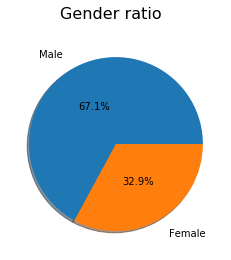

In [8]:
gender_count = gender_roles.gender.value_counts()
labels = 'Male', 'Female'
explode = 0, 0

plt.pie(gender_count,  autopct='%1.1f%%', startangle=0, explode= explode, labels= labels, shadow= True, pctdistance = 0.5, labeldistance = 1.2)
plt.suptitle('Gender ratio', fontsize=16)

plt.show()

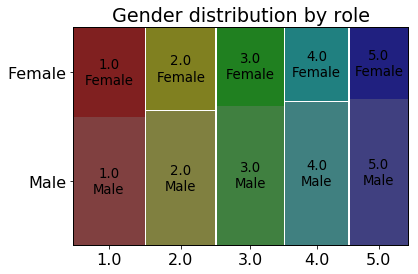

In [9]:
plt.rcParams['font.size'] = 16.0
mosaic(gender_roles.loc[gender_roles.credits_order <= 5], ['credits_order', 'gender'],title='Gender distribution by role');

As the mosaic grpah shows, the number of male actors is superior to their correspondant female counterparts. It is also notable that the diference increases as we progress through the credits.

This is indicative of a missrepresentation of women across the differente film genres. Thus it becomes necessary to further explore this difference and see how it affects the rest of the data. For readabiliy reasons, a top number of 20 has been selected to determine the roles to investigate. This is motivated by the fact that as the focus moves away from the top of the list (1st billing), the importance of the role diminishes. And with importance comes screen-time, plot-interference and number of lines.

In [10]:
stage1 = gender_roles.groupby('credits_order').gender.value_counts().head(40)
stage1 = list(stage1)

male = []
female = []

for n in range(len(stage1)):
    if (n % 2) == 0:
        male.append(stage1[n])
    else:
        female.append(stage1[n])
print ("Done")

Done


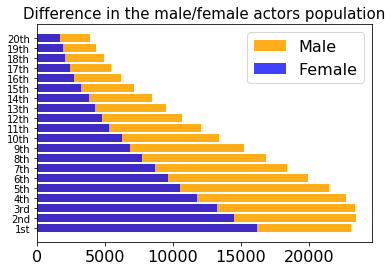

In [11]:
# Data assembly
objects = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th','9th', '10th', '11th','12th', '13th', '14th', '15th', '16th', '17th', '18th','19th', '20th']
y_pos = np.arange(len(objects))
data = male
data2 = female

# Creating the plots
plt.barh(y_pos, data, align='center', alpha=0.9, color= 'orange')
plt.barh(y_pos, data2, align='center', alpha=0.75, color= 'blue')
plt.yticks(y_pos, objects, fontsize=10)


# Cretaing labels and titles
plt.title('Difference in the male/female actors population', fontsize=15)
plt.legend(labels, loc= 'best')


plt.show()

As shown before, a clear missrepresentation of women occurs across the credits. This difference is most notable, and more important, the closer the data is to the top billing (1st). As stated before, the gender ratio difference exists and is notable all across the whole spectrum of roles.


It is expected that an even wider difference might occur when taking into account the different film genres identified.

1.1 Gender across film genres

In [12]:
dfgu = genres_unique            # for easier typing, genres_unique will be renamed to dfgu

In [13]:
genres.head(1), actors.head(1)

(   Unnamed: 0   id                      genre
 0           0  862  Animation, Comedy, Family,
    Unnamed: 0   id  credits_order       name gender
 0           1  862            1.0  Tim Allen   Male)

In [14]:
#  No NaN data in "id" columns
genres.id.isnull().any(), actors.id.isnull().any()

(False, False)

In [15]:
# Function previously ocupying this cell has been deleted. Complexity was overwhelmingly high. New approach: to create a df with the following columns: Id, genre, gender, gender_counts. This should allow an easier count using dfX.groupby('genre')['gender'].value_counts()

# Literal eval method to be used in the creation of the new df.

In [16]:
producers.id.dtype, directors.id.dtype, genres.id.dtype

(dtype('float64'), dtype('float64'), dtype('int64'))

In [17]:
print(actors.columns)
actors = actors.drop('Unnamed: 0', axis=1)
print(actors.columns)

print(producers.columns)
producers = producers.drop('Unnamed: 0', axis=1)
print(producers.columns)

print(directors.columns)
directors = directors.drop('Unnamed: 0', axis=1)
print(directors.columns)

print(genres.columns)
genres = genres.drop('Unnamed: 0', axis=1)
print(genres.columns)

print(genres_unique.columns)
genres_unique = genres_unique.drop('Unnamed: 0', axis=1)
print(genres_unique.columns)

Index(['Unnamed: 0', 'id', 'credits_order', 'name', 'gender'], dtype='object')
Index(['id', 'credits_order', 'name', 'gender'], dtype='object')
Index(['Unnamed: 0', 'id', 'name', 'gender'], dtype='object')
Index(['id', 'name', 'gender'], dtype='object')
Index(['Unnamed: 0', 'id', 'name', 'gender'], dtype='object')
Index(['id', 'name', 'gender'], dtype='object')
Index(['Unnamed: 0', 'id', 'genre'], dtype='object')
Index(['id', 'genre'], dtype='object')
Index(['Unnamed: 0', 'Genre'], dtype='object')
Index(['Genre'], dtype='object')


In [18]:
# Stage 1
actors_gender_genre = mixer(actors, genres)
producers_gender_genre = mixer(producers, genres)
directors_gender_genre = mixer(directors, genres)

In [19]:
# Stage 2, ready for plotting
actors_gender_by_genre = corresponder(actors_gender_genre, genres_unique)
producers_gender_by_genre = corresponder(producers_gender_genre, genres_unique)
directors_gender_by_genre = corresponder(directors_gender_genre, genres_unique)

actors_gender_by_genre.head()

,Genre,male_counts,female_counts
0,Animation,427,229
1,Comedy,24941,14418
2,Family,506,300
3,Adventure,889,310
4,Fantasy,329,142



Gender ratio across genres - Actors


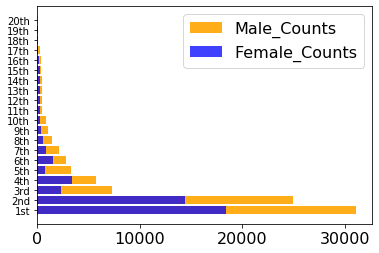


Gender ratio across genres - Producers


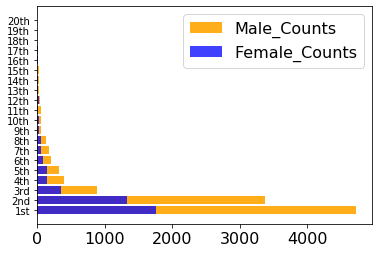


Gender ratio across genres - Directors


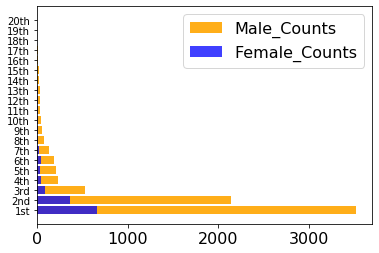

In [21]:
print("\nGender ratio across genres - Actors")
plotter_special(actors_gender_by_genre)

print("\nGender ratio across genres - Producers")
plotter_special(producers_gender_by_genre)

print("\nGender ratio across genres - Directors")
plotter_special(directors_gender_by_genre)